In [1]:
import geopandas as gpd
import folium

# Load the GeoJSON
gdf = gpd.read_file("easternshore.geojson")

# Reproject to Web Mercator (EPSG:3857) for accurate centroid
gdf_proj = gdf.to_crs(epsg=3857)

# Calculate centroid in projected space
centroid_proj = gdf_proj.geometry.centroid.iloc[0]

# Transform centroid back to WGS84 (EPSG:4326) for folium
centroid_wgs = gpd.GeoSeries(centroid_proj, crs=3857).to_crs(epsg=4326).geometry.iloc[0]

# Create folium map centered at the correct location
m = folium.Map(location=[centroid_wgs.y, centroid_wgs.x], zoom_start=8)

# Add GeoJSON to the map (original data in EPSG:4326)
folium.GeoJson(gdf).add_to(m)

m

In [2]:
tif_path = "data/sentinel_eastern_shore_2018-06-01_2018-06-30.tif"

In [3]:
from rasterio.windows import Window
import rasterio
import numpy as np

with rasterio.open(tif_path) as src:
    try:
        img = src.read(1)
        print(np.unique(img))
    except rasterio.errors.RasterioIOError as e:
        print(f"Failed to read block: {e}")


[   51.    57.    60. ... 12848. 17904.    nan]


In [4]:
from data_downloader import get_mission, compute_ndwi

In [5]:
sentinel_mission = get_mission("sentinel-2")

11096 20559
Found non-NaN data at x=0, y=19712


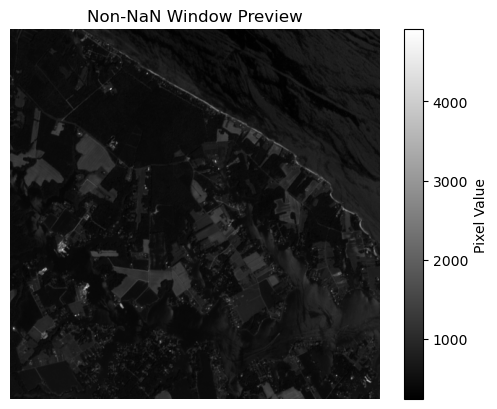

In [7]:
import matplotlib.pyplot as plt

def find_non_nan_window(tif_path, window_size=512, stride=256):
    with rasterio.open(tif_path) as src:
        width, height = src.width, src.height
        print(width, height)

        for y in range(0, height - window_size + 1, stride):
            for x in range(0, width - window_size + 1, stride):
                window = Window(x, y, window_size, window_size)
                data = src.read(1, window=window)

                if np.isnan(data).any():
                    continue  # Skip blank windows
                else:
                    print(f"Found non-NaN data at x={x}, y={y}")
                    green_data = src.read(sentinel_mission["band_index"]["green"], window=window)
                    nir_data = src.read(sentinel_mission["band_index"]["nir08"], window=window)

                    # Get the window transform
                    window_transform = src.window_transform(window)
                    windowed_profile = src.profile.copy()
                    windowed_profile.update({
                        "height": window.height,
                        "width": window.width,
                        "transform": window_transform
                    })
                    return green_data, nir_data, windowed_profile  # Or return (data, x, y) if needed

    print("No non-NaN windows found.")
    return None

# Usage
green_data, nir_data, profile = find_non_nan_window(tif_path)
window_data = green_data

if window_data is not None:
    plt.imshow(window_data, cmap='gray')
    plt.colorbar(label="Pixel Value")
    plt.title("Non-NaN Window Preview")
    plt.axis('off')
    plt.show()


In [8]:
# # Usage
# with rasterio.open(tif_path) as src:
#     green_data = src.read(sentinel_mission["band_index"]["green"])
#     nir_data = src.read(sentinel_mission["band_index"]["nir08"])
#     profile = src.profile.copy()

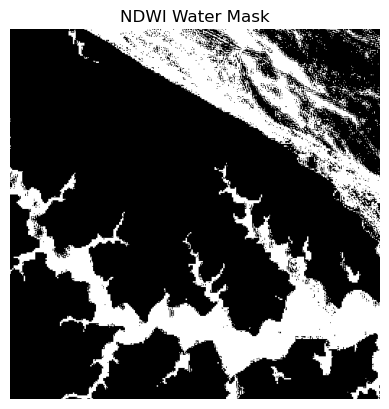

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.]], shape=(512, 512))

In [9]:
compute_ndwi(green_data, nir_data, profile, out_path=None, display=True)